<a href="https://colab.research.google.com/github/Miolith/nlp3-labs/blob/master/lab2/LabIIpart2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

II. Rotate two semantic spaces (23 points) - Not guided coding

In [1]:
# our own fork of MUSE, the library doesn't
# seem to work on Google Colab otherwise
!git clone https://github.com/Miolith/MUSE.git

Cloning into 'MUSE'...
remote: Enumerating objects: 239, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 239 (delta 0), reused 1 (delta 0), pack-reused 233
Receiving objects: 100% (239/239), 222.07 KiB | 22.21 MiB/s, done.
Resolving deltas: 100% (134/134), done.


In [4]:
!pip install faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!cd MUSE

In [7]:
# English fastText Wikipedia embeddings
!curl -Lo data/wiki.en.vec https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.en.vec
# French fastText Wikipedia embeddings
!curl -Lo data/wiki.fr.vec https://dl.fbaipublicfiles.com/fasttext/vectors-wiki/wiki.fr.vec

[Errno 2] No such file or directory: 'MUSE'
/content/MUSE
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6291M  100 6291M    0     0  10.0M      0  0:10:23  0:10:23 --:--:-- 9916k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2886M  100 2886M    0     0  12.7M      0  0:03:45  0:03:45 --:--:-- 11.2M


In [ ]:
%%capture
!python unsupervised.py --src_lang fr --tgt_lang en --src_emb data/wiki.fr.vec --tgt_emb data/wiki.en.vec --n_epochs 1 --exp_name "fr_to_en" --exp_path "./" --export ""

In [15]:
from glob import glob
fr_eng_id = glob("fr_to_en/*")[0]

In [16]:
fr_eng_id

'fr_to_en/owoqmmzp8s'

In [24]:
import torch
mapping = torch.nn.Linear(300,300, bias=False)
mapping.weight.data = torch.tensor(torch.load(fr_eng_id + "/best_mapping.pth"))
mapping

Linear(in_features=300, out_features=300, bias=False)

In [26]:
import io
import numpy as np

def load_vec(emb_path, nmax=50000):
    vectors = []
    word2id = {}
    with io.open(emb_path, 'r', encoding='utf-8', newline='\n', errors='ignore') as f:
        next(f)
        for i, line in enumerate(f):
            word, vect = line.rstrip().split(' ', 1)
            vect = np.fromstring(vect, sep=' ')
            assert word not in word2id, 'word found twice'
            vectors.append(vect)
            word2id[word] = len(word2id)
            if len(word2id) == nmax:
                break
    id2word = {v: k for k, v in word2id.items()}
    embeddings = np.vstack(vectors)
    return embeddings, id2word, word2id

src_embeddings, src_id2word, src_word2id = load_vec("data/wiki.fr.vec")
tgt_embeddings, tgt_id2word, tgt_word2id = load_vec("data/wiki.en.vec")

In [55]:
from sklearn.decomposition import PCA

def reduce_dimension(src, tgt):
    pca = PCA(n_components=2, whiten=True)
    pca.fit(np.vstack([src, tgt]))
    return pca


In [69]:
import matplotlib.pyplot as plt


def plot_similar_word(src_words, src_word2id, src_emb, tgt_words, tgt_word2id, tgt_emb, pca, title):

    Y = []
    word_labels = []
    for sw in src_words:
        Y.append(src_emb[src_word2id[sw]])
        word_labels.append(sw)
    for tw in tgt_words:
        Y.append(tgt_emb[tgt_word2id[tw]])
        word_labels.append(tw)

    # find pca coords for 2 dimensions
    Y = pca.transform(Y)
    x_coords = Y[:, 0]
    y_coords = Y[:, 1]

    # display scatter plot
    plt.figure(figsize=(8, 6), dpi=80)
    plt.scatter(x_coords, y_coords, marker='x')

    for k, (label, x, y) in enumerate(zip(word_labels, x_coords, y_coords)):
        color = 'blue' if k < len(src_words) else 'red'  # src words in blue / tgt words in red
        plt.annotate(label, xy=(x, y), xytext=(4, 4), textcoords='offset points', fontsize=16,
                     color=color)

    plt.xlim(x_coords.min() - 0.2, x_coords.max() + 0.2)
    plt.ylim(y_coords.min() - 0.2, y_coords.max() + 0.2)
    plt.title(title, fontsize=16)

    plt.show()

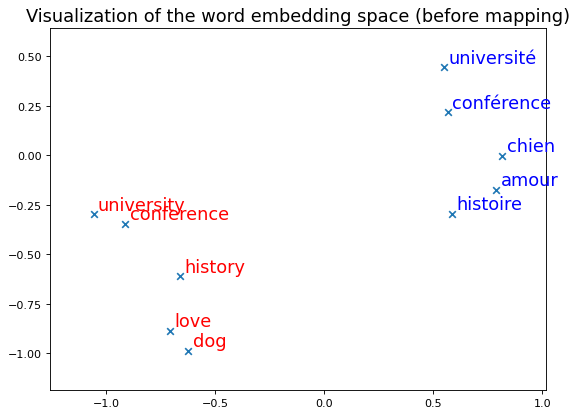

In [70]:
src_words = [u'université', 'amour', 'histoire', u'conférence', 'chien']
tgt_words = ['university', 'love', 'history', 'conference', 'dog']


# assert words in dictionaries
for sw in src_words:
    assert sw in src_word2id, '"%s" not in source dictionary' % sw
for tw in tgt_words:
    assert tw in tgt_word2id, '"%s" not in target dictionary' % sw

pca = reduce_dimension(src_embeddings, tgt_embeddings)
plot_similar_word(src_words, src_word2id, src_embeddings,
                  tgt_words, tgt_word2id, tgt_embeddings,
                  pca,
                  'Visualization of the word embedding space (before mapping)'
                  )

In [71]:
mapped_embed_src = [mapping(torch.from_numpy(e).float()).detach().numpy() for e in src_embeddings]

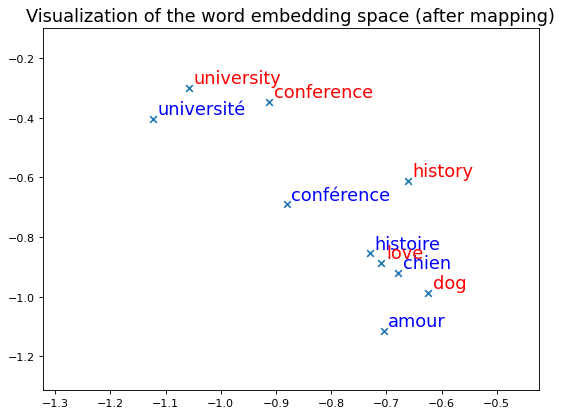

In [72]:
pca_map = reduce_dimension(mapped_embed_src, tgt_embeddings)

plot_similar_word(src_words, src_word2id, mapped_embed_src,
                  tgt_words, tgt_word2id, tgt_embeddings,
                  pca,
                  'Visualization of the word embedding space (after mapping)'
                  )

In [75]:
def get_nn(word, src_emb, src_id2word, tgt_emb, tgt_id2word, K=5):
    print("Nearest neighbors of \"%s\":" % word)
    word2id = {v: k for k, v in src_id2word.items()}
    word_emb = src_emb[word2id[word]]
    scores = (tgt_emb / np.linalg.norm(tgt_emb, 2, 1)[:, None]).dot(word_emb / np.linalg.norm(word_emb))
    k_best = scores.argsort()[-K:][::-1]
    for i, idx in enumerate(k_best):
        print('%.4f - %s' % (scores[idx], tgt_id2word[idx]))

def translate_fr_to_en(src_word):
    get_nn(src_word, mapped_embed_src, src_id2word, tgt_embeddings, tgt_id2word, K=5)

In [78]:
for w in src_words:
    translate_fr_to_en(w)
    print()

Nearest neighbors of "université":
0.8894 - university
0.7790 - faculty
0.7130 - universityuniversity
0.6767 - professor
0.6703 - wisconsin–madison

Nearest neighbors of "amour":
0.7338 - love
0.6439 - unrequited
0.6349 - longing
0.6126 - lover
0.6063 - affection

Nearest neighbors of "histoire":
0.7363 - history
0.5442 - prehistory
0.5373 - histories
0.5295 - historiography
0.5231 - historical

Nearest neighbors of "conférence":
0.7318 - conference
0.6318 - conferences
0.5806 - meeting
0.5565 - plenary
0.5462 - convened

Nearest neighbors of "chien":
0.7598 - dog
0.6263 - dogs
0.6057 - poodle
0.5823 - puppies
0.5797 - puppy

